# Clasificación de imágenes y explicación con LIME
***
* LIME permite identificar los superpixels de la imagen que contribuyen positiva o negativamente en las predicciones generadas por el clasificador
* Ejemplo basado en [Tutorial LIME: Tutorial - Image Classification Keras.ipynb](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb)

## Bibliotecas

In [ ]:
import os
import keras
from keras.applications import inception_v3 as inc_net
#from keras.preprocessing import image
import keras.utils as image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
print('Notebook run using keras:', keras.__version__)

## Uso de Inception V3
***
* El modelo InceptionV3 preentrenado está disponible en Keras y es usado para clasificación de imágenes y tiene un desempeño de  78,1% de accuracy en el conjunto de datos de ImageNet.
* Para revisar la arquitectura CNN Inceptión, revisar [acá](https://arxiv.org/abs/1512.00567v3)
* La documentación del módulo inception_v3 de Keras, en este [link](https://keras.io/api/applications/inceptionv3/)
* El diagrama de la arquitectura [acá](https://paperswithcode.com/method/inception-v3)

In [ ]:
inet_model = inc_net.InceptionV3()

* Transformación de la imagen al formato y dimensión requeridas

In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

In [ ]:
images = transform_img_fn([os.path.join('data','anemone.jpg')])
plt.figure()
plt.imshow(images[0] / 2 + 0.5)
#plt.imshow(images[0])
plt.show()


## Predicción en la imagen de prueba

In [ ]:
preds = inet_model.predict(images) # vector de tamaño 1000

Se muestran los primeros 6 puntajes de clasificación, y se observa que "anemone fish" es la primera predicción para la imagen, con un puntaje de 0.71

In [ ]:
for x in decode_predictions(preds,top=6)[0]:
    print("Predicción clase: ",x[1], "con puntaje: ",x[2])

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) 
    import lime
from lime import lime_image

## Explicación usando LimeImageExplainer()
***
[Documentación](https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=submodular_pick#module-lime.lime_image) de lime_image.

In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. 
# Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), 
                                         inet_model.predict, 
                                         top_labels=6, 
                                         hide_color=0, 
                                         num_samples=1000)

## Segmentos o superpíxeles generados

In [ ]:
explanation.segments.max()

In [ ]:
explanation.segments

In [ ]:
plt.imshow(explanation.segments)
plt.axis('off')
plt.show()

## Visualización de los superpíxeles que contribuyen a la predicción
***
* Uso de módulo [scikit-image](https://scikit-image.org), el cual provee un gran número de algoritmos para procesamiento de imágenes

In [ ]:
from skimage.segmentation import mark_boundaries

* Se genera una explicación usando la función get_image_and_mask, la cual recibe como parámetros:
 * label = la etiqueta de la clase que se quiere explicar
 * positive_only = True, para tomar superpixeles que solo contribuyen de manera positiva a la predicción
 * num_features = número de superpíxeles para incluir en la explicación
 * hide_rest = True, para dejar en color gris las regiones no explicadas

### Visualización de superpíxeles que contribuyen positivamente a la predicción de la clase indicada

In [ ]:
for x in decode_predictions(preds,top=6)[0]:
    print("Predicción clase: ",x[1], "con puntaje: ",x[2])

In [ ]:
#anemone_fish: pez de las anémonas o pez payaso
#sea_anemone: anémona de mar
#coral_reef: arrecife de coral
#rock_beauty: Rock Beauty Fish
#scuba_diver:buceador
#sea_urchin: erizo de mar

temp, mask = explanation.get_image_and_mask(label= explanation.top_labels[0], 
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=True)

In [ ]:
plt.figure()
plt.title("Explicación de 'pez payaso'")
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de la imagen completa, y segmentación de los superpíxeles que contribuyen positivamente a la predicción de la clase indicada
* Acá no se ocultan los superpixeles que no contribuyen a la clasificación indicada

In [ ]:
temp, mask = explanation.get_image_and_mask(label = explanation.top_labels[0],
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)

In [ ]:
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de superpíxeles que contribuyen positivamente a la predicción de la clase indicada
* Ahora consideramos un número mayor de superpíxeles para la explicación


In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                            positive_only=False,
                                            num_features=10, 
                                            hide_rest=False)

In [ ]:
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.show()

### Visualización de los pesos en un mapa de calor
***
* explanation.local_exp es un diccionario de tamaño 6 (en este ejemplo), donde cada llave corresponde es una de las 6 clases, y su valor, es una lista que contiene los pesos de cada superpíxel.

In [ ]:
#Selección de la clase, acá tomamos la primera clase indicada por el inception_v3
ind =  explanation.top_labels[0]

#Se asocia cada peso de la explicación a su superpixel correspondiente
dict_heatmap = dict(explanation.local_exp[ind])  # se toman los pesos de la clase ind
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) # se genera mapa de calor

In [ ]:
plt.figure()
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()
plt.show()

<div class="alert-success">
    <h2>Ejercicio 1</h2>
    <hr>
    <ul>
        <li> Considere ahora la imagen mostrada a continuación. </li>
        <li>Genere la clasificación usando la CNN Inception V3 y explique (de acuerdo a los ejemplos anteriores) las cuatro primeras clasificaciones entregadas por la CNN.</li>
        <li>Analice la predicción genererada por el clasificador (puntaje/score) y las explicaciones para cada clase generada por LIME. Comente.</li>
    </ul>
</div>

<div>
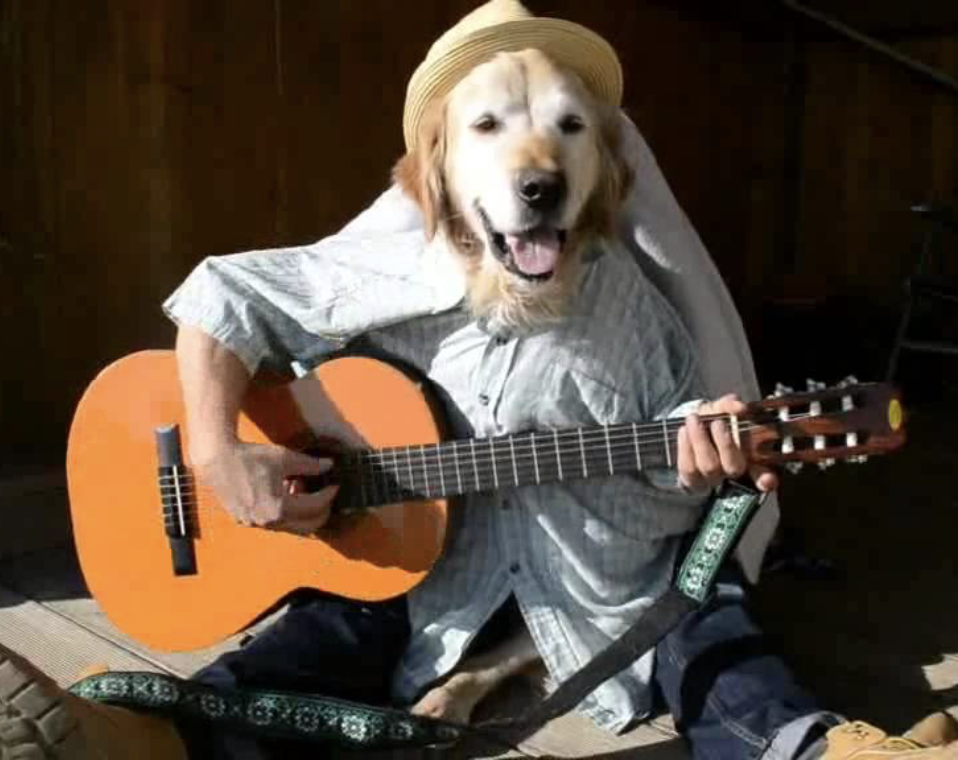
</div>